# The Beatles' Covers Recognition

In [74]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy import ndimage
from rapidfuzz import process, fuzz
import json

COVERS_FOLDER_INPUT = "beatles_covers"
COVERS_FOLDER_OUTPUT = "beatles_covers_stft"
BEATLES_FOLDER_INPUT = "beatles_songs"
BEATLES_FOLDER_OUTPUT = "beatles_songs_stft"

## Generating the spectograms

In [75]:
def process_audio(file_name, input_folder, output_folder, duration=30, sr=22050):
    y, _ = librosa.load(f"{input_folder}/{file_name}", sr=sr, duration=duration)

    # Trim initial silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=30)
    y_trimmed = y_trimmed[:int(duration * sr)]

    D = librosa.stft(y_trimmed)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    np.save(f"{output_folder}/{file_name}", D_db)

In [ ]:
def generate_spectograms(folder_input, folder_output):
    for file in os.listdir(folder_input):
        output_file = f"{folder_output}/{file}.npy"

        if os.path.exists(output_file):
            print(f"Skipping {file}: Output file already exists.")
            continue

        try:
            process_audio(file, folder_input, folder_output)
        except Exception as e:
            print(f"Error processing {file}: {e}")

generate_spectograms(COVERS_FOLDER_INPUT, COVERS_FOLDER_OUTPUT)
generate_spectograms(BEATLES_FOLDER_INPUT, BEATLES_FOLDER_OUTPUT)

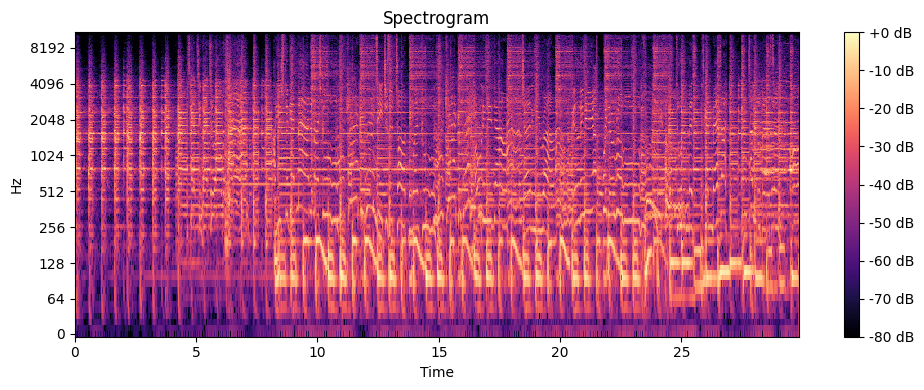

In [77]:
def plot_spectrogram(stft, constellation=None):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(stft, sr=22050, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()

    if constellation is not None and constellation.any():
        freqs = librosa.fft_frequencies(sr=22050, n_fft=2*(stft.shape[0]-1))
        times = librosa.frames_to_time(np.arange(stft.shape[1]), sr=22050, hop_length=512)
        x, y = np.where(constellation.T)
        plt.scatter(times[x], freqs[y], s=100, alpha=0.6, edgecolor='k')

    plt.show()

example_stft = np.load(f"{BEATLES_FOLDER_OUTPUT}/04 The Beatles - Getting Better.flac.npy")
plot_spectrogram(example_stft)

## Labeling the data

I've generated the `labels.json` file, but some stuff were missing and some misplaced, so I had to manually alter some songs. Final labels on `labels_final.json`

In [79]:
def clean_beatles_song_name(filename):
    filename = re.sub(r"\.(flac|mp4)\.npy$", "", filename)
    filename = re.sub(r"\[.*?\]", "", filename).strip()
    filename = filename.replace("(Remastered 2009)", "").strip()
    filename = re.sub(r"^\d+\s*", "", filename)
    filename = re.sub(r"(?i)^the beatles\s*-\s*", "", filename)

    return filename

def clean_cover_name(filename):
    filename = re.sub(r"\.mp4\.npy$", "", filename)
    filename = re.sub(r"\[.*?\]", "", filename).strip()
    filename = re.sub(r"\bcover\b", "", filename, flags=re.IGNORECASE).strip()
    filename = re.sub(r"\bbeatles\b", "", filename, flags=re.IGNORECASE).strip()
    
    return filename

def match_covers_to_songs(beatles_songs, covers):
    song_dict = {file_name: [] for _, file_name in beatles_songs}
    beatles_cleaned_songs = [clean_name for clean_name, _ in beatles_songs]
    song_name_to_file = {clean_name: file_name for clean_name, file_name in beatles_songs}

    for cover_name, original_name in covers:
        best_match, score, _ = process.extractOne(cover_name, beatles_cleaned_songs, scorer=fuzz.ratio)

        if score > 40:
            original_song_file = song_name_to_file[best_match]
            song_dict[original_song_file].append(original_name)
        else:
            print(f"Not labeled: {original_name}")

    return {k: v for k, v in song_dict.items()}

cleaned_beatles_songs = [(clean_beatles_song_name(f), f) for f in os.listdir(BEATLES_FOLDER_OUTPUT)]
cleaned_covers = [(clean_cover_name(f), f) for f in os.listdir(COVERS_FOLDER_OUTPUT)] 

matches = match_covers_to_songs(cleaned_beatles_songs, cleaned_covers)
with open("labels.json", "w", encoding="utf-8") as f:
    json.dump(matches, f, indent=4, ensure_ascii=False)

Not labeled: Robin Williams & Bobby McFerrin - Come Together (George Martin： In My Life CD) [j6VbspP47oY].mp4.npy
Not labeled: Ringo Starr playing with The Beach Boys July 4th 1984 1 [kINQXKLm334].mp4.npy
Not labeled: Sacred Rite ＂Eleanor Rigby (Beatles Cover)＂ Album： Is Nothing Sacred [mVKOcWia8_k].mp4.npy
Not labeled: Stefanie Hempel ALL THINGS MUST PASS [hhQ3hSPZLDk].mp4.npy
Not labeled: St Vincent - Dig A Pony - Live @ All Points West Festival 8⧸1⧸09 in HD [lan-UQfN0zs].mp4.npy
Not labeled: Frank Zappa Beatles medley - Cleveland 5th March 1988 [_kna4NiU-eM].mp4.npy
Not labeled: LOS FABULOSOS CADILLACS - TWIST Y GRITOS - VIVO -  1989 [nuuyOAy-TBo].mp4.npy
Not labeled: Amy Winehouse - All my lovin' (The Beatles's cover) [9FiQnrRT16s].mp4.npy
Not labeled: Joe Jackson covers John Lennon's Girl (live 2010) HD [cVJ8tKvpmE4].mp4.npy
Not labeled: CHER ＂THE LONG AND WINDING ROAD＂ (1973) STUDIO RECORDING [nziq7ZkqSeE].mp4.npy
Not labeled: Jimmy Page & Yes - I'm Down (Beatles cover) [j90CnFv3

## Constellation Map
kappa: Controls frequency sensitivity. Increasing it will group fewer but stronger peaks.<br>
tau: Defines the region in time to consider as a local maximum. Increasing it reduces the number of peaks.<br>
threshold: Since your STFT values are in dB, this threshold is detecting even quieter points.

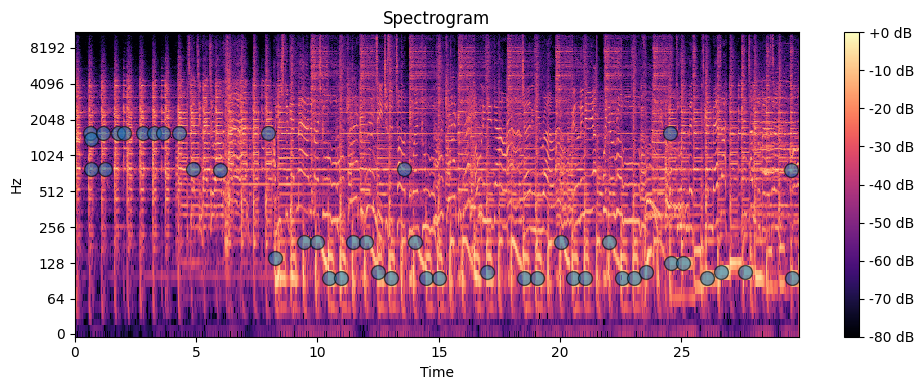

In [35]:
def constellation_map(stft, kappa=7, tau=7, thresh=-5):
    result = ndimage.maximum_filter(stft, size=[2*kappa+1, 2*tau+1], mode='constant')
    C = np.logical_and(stft == result, result > thresh)
    return C

constellation = constellation_map(example_stft)
plot_spectrogram(example_stft, constellation)